In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import IPython

sns.set_theme() # Setting seaborn as default style

### Options

In [14]:
# Years of electricity map (EM) data that will be imported
years = [2020, 2021]

# Features that will be extracted from the EM data
features = ["power_production_wind_avg",
            "power_production_solar_avg",
            "total_consumption_avg"]
# Feature short names that will be used in the final data frame
short_names = ["prod_wind",
               "prod_solar",
               "total_consumption"]


## Import electricity data

In [3]:
# Import Electricity Map data
em_list = []

for year in years:
    em_list.append(pd.read_csv(f"..\data\electricity-map\ElectricityMap_DE_{year}.csv", sep=",",
                               parse_dates=["datetime"], index_col=["datetime"]))
em = pd.concat(em_list, axis=0, ignore_index=False, verify_integrity=True)
em.shape


(17544, 94)

In [13]:
print(em.dtypes)
# print(em.columns)

created_at                                        object
updated_at                                        object
timestamp                                          int64
zone_name                                         object
carbon_intensity_avg                             float64
                                                  ...   
latest_forecasted_power_net_import_PL_avg        float64
latest_forecasted_power_net_import_SE_avg        float64
latest_forecasted_power_net_import_SE-SE4_avg    float64
latest_forecasted_production_solar_avg           float64
latest_forecasted_production_wind_avg            float64
Length: 94, dtype: object


In [5]:
# Print types of columns
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(em.dtypes)

In [6]:
# Is datetime in UTC? -> Does datetime match with timestamp?
# timestamp1 = data["datetime"].apply(pd.Timestamp.timestamp)
timestamp1 = em.index.to_series().apply(pd.Timestamp.timestamp)
timestamp2 = em["timestamp"].astype(float)

timestamp1.equals(timestamp2)

True

No time zone correction of datetime necessary.

## Extract relevant features

In [16]:
# extract the relevant data
df = pd.DataFrame(em, columns=features)
# rename columns
features_dict = dict(zip(features, short_names))
df = df.rename(columns=features_dict)
df.head()

,prod_wind,prod_solar,total_consumption
datetime,,,
2020-01-01 00:00:00+00:00,6989.50,0.0,38477.88
2020-01-01 01:00:00+00:00,7371.25,0.0,38507.32
2020-01-01 02:00:00+00:00,7447.75,0.0,37347.52
2020-01-01 03:00:00+00:00,7699.25,0.0,36780.21
2020-01-01 04:00:00+00:00,7703.00,0.0,36078.11


## Statistics of the data

In [17]:
df.describe()

,prod_wind,prod_solar,total_consumption
count,17544.000000,17544.000000,17544.000000
mean,13886.152388,5268.331823,53397.439576
std,10325.899628,8058.754017,9165.878850
min,135.750000,0.000000,31923.000000
25%,5605.750000,0.000000,45967.910000
50%,11166.250000,168.250000,52982.115000
75%,20123.000000,8548.250000,61286.760000
max,46953.250000,36175.250000,74973.020000


## Plot data

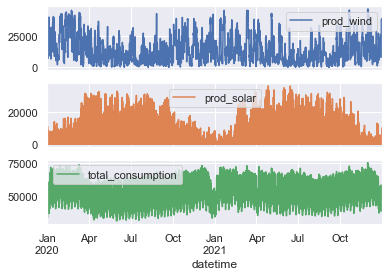

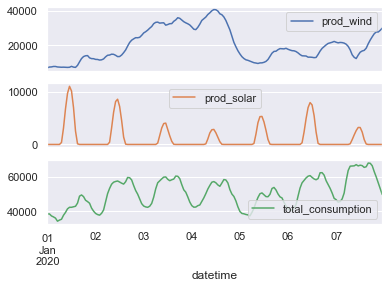

In [21]:
# plot whole year
df.plot(subplots=True)
# plot first 10 days
_ = df[0:7*24].plot(subplots=True)

## Determining the most important frequencies

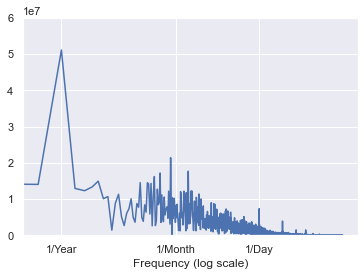

In [10]:
fft = np.fft.rfft(df["prod_wind"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df["prod_wind"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.plot(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 6e7)
# plt.xlim(.5, max(plt.xlim()))
plt.xticks([1, 30.44, 365.2524],
           labels=['1/Year', '1/Month', '1/Day'])
_ = plt.xlabel('Frequency (log scale)')

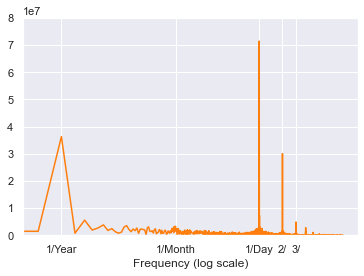

In [11]:
fft = np.fft.rfft(df["prod_solar"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df["prod_solar"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.plot(f_per_year, np.abs(fft), 'tab:orange')
plt.xscale('log')
plt.ylim(0, 8e7)
# plt.xlim([1, max(plt.xlim())])
plt.xticks([1, 30.44, 365.2524, 365.2524*2, 365.2524*3],
           labels=['1/Year', '1/Month', '1/Day', '2/', '3/'])
_ = plt.xlabel('Frequency (log scale)')

## Create periodical time signals

In [12]:
day_s = 24*60*60
year_s = (365.2425)*day_s
timestamp_s = em["timestamp"]

df["day_sin"] = np.sin(timestamp_s * (2 * np.pi / day_s))
df["day_cos"] = np.cos(timestamp_s * (2 * np.pi / day_s))
df["year_sin"] = np.sin(timestamp_s * (2 * np.pi / year_s))
df["year_cos"] = np.cos(timestamp_s * (2 * np.pi / year_s))

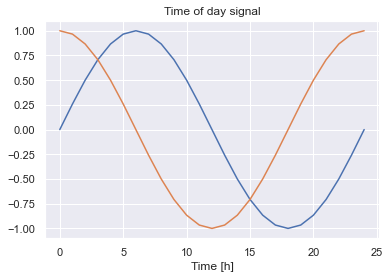

In [13]:
# plotting a day
plt.plot(np.array(df["day_sin"])[:25])
plt.plot(np.array(df["day_cos"])[:25])
plt.xlabel('Time [h]')
_ = plt.title('Time of day signal')

## Create solar elevation from ground
The angle varies with the location. We calculate a single feature for the [center of Germany](https://de.wikipedia.org/wiki/Mittelpunkte_Deutschlands) (♁51° 8′ 0″ N, 10° 25′ 0″ O, determined by the center of gravity of the surface 😉) and the [mean height of Germany](https://de.wikipedia.org/wiki/Liste_der_L%C3%A4nder_nach_durchschnittlicher_H%C3%B6he) (263 m)

In [14]:
import pvlib
from pvlib.location import Location

# create location object
site = Location(51.133, 10.416, altitude=263, tz="UTC", name='COG, Germany')

# estimate the solar position
solpos = site.get_solarposition(df.index)
solpos.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
datetime,,,,,,
2020-01-01 00:00:00+00:00,150.949049,150.949049,-60.949049,-60.949049,18.508437,-3.081724
2020-01-01 01:00:00+00:00,146.073363,146.073363,-56.073363,-56.073363,43.415883,-3.101587
2020-01-01 02:00:00+00:00,138.553549,138.553549,-48.553549,-48.553549,62.463520,-3.121441
2020-01-01 03:00:00+00:00,129.725411,129.725411,-39.725411,-39.725411,77.304319,-3.141287
2020-01-01 04:00:00+00:00,120.389395,120.389395,-30.389395,-30.389395,89.747901,-3.161123


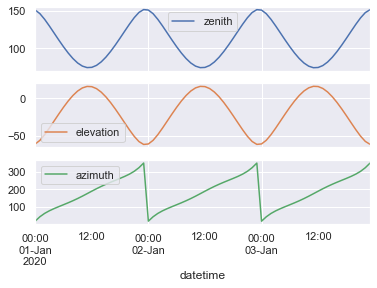

In [15]:
# plot features
_ = solpos.iloc[:72][["zenith", "elevation", "azimuth"]].plot(subplots=True)

In [16]:
# append solar elevation to dataframe
df["solar_el"] = solpos["elevation"]

# clip elevation below zero?
df["solar_el_clip"] = df["solar_el"].clip(lower=0)

In [17]:
df.head()

,prod_wind,prod_solar,day_sin,day_cos,year_sin,year_cos,solar_el,solar_el_clip
datetime,,,,,,,,
2020-01-01 00:00:00+00:00,6989.50,0.0,-7.670342e-12,1.000000,-2.150345e-03,0.999998,-60.949049,0.0
2020-01-01 01:00:00+00:00,7371.25,0.0,2.588190e-01,0.965926,-1.433564e-03,0.999999,-56.073363,0.0
2020-01-01 02:00:00+00:00,7447.75,0.0,5.000000e-01,0.866025,-7.167823e-04,1.000000,-48.553549,0.0
2020-01-01 03:00:00+00:00,7699.25,0.0,7.071068e-01,0.707107,1.964387e-15,1.000000,-39.725411,0.0
2020-01-01 04:00:00+00:00,7703.00,0.0,8.660254e-01,0.500000,7.167823e-04,1.000000,-30.389395,0.0


## Preview of data normalization
We can't do this in this notebook yet, since all the data should be normalized over the training set and not the whole set (so the network doen't get an implicit preview of test values during training).

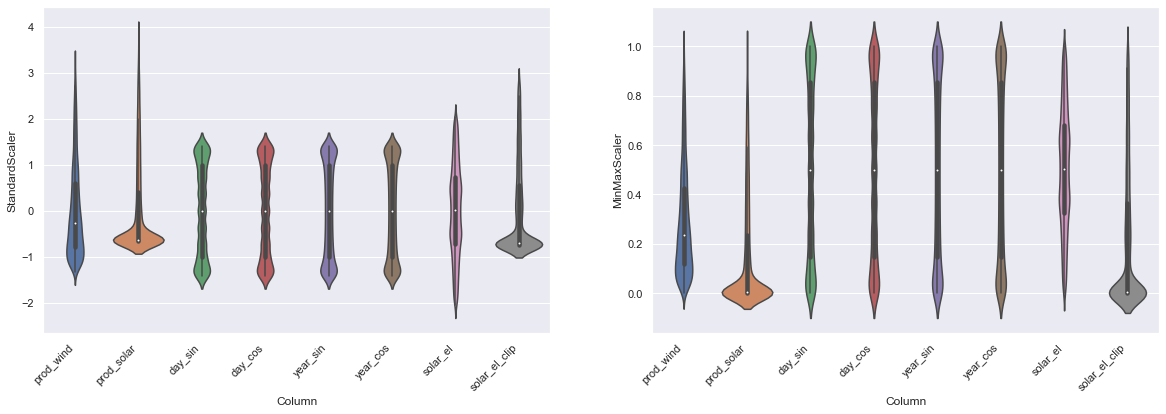

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Standardize dataframe
df_std = pd.DataFrame(StandardScaler().fit_transform(df),
                      columns=df.columns, index=df.index)
# Rescale / min-max normalize dataframe
df_scl = pd.DataFrame(MinMaxScaler().fit_transform(df),
                      columns=df.columns, index=df.index)

# plot normalizations
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
sns.violinplot(ax=axes[0], x='Column', y='StandardScaler',
               data=df_std.melt(var_name='Column', value_name='StandardScaler'))
sns.violinplot(ax=axes[1], x='Column', y='MinMaxScaler',
               data=df_scl.melt(var_name='Column', value_name='MinMaxScaler'))
axes[0].set_xticklabels(df.keys(), rotation=45, ha="right")
_ = axes[1].set_xticklabels(df.keys(), rotation=45, ha="right")


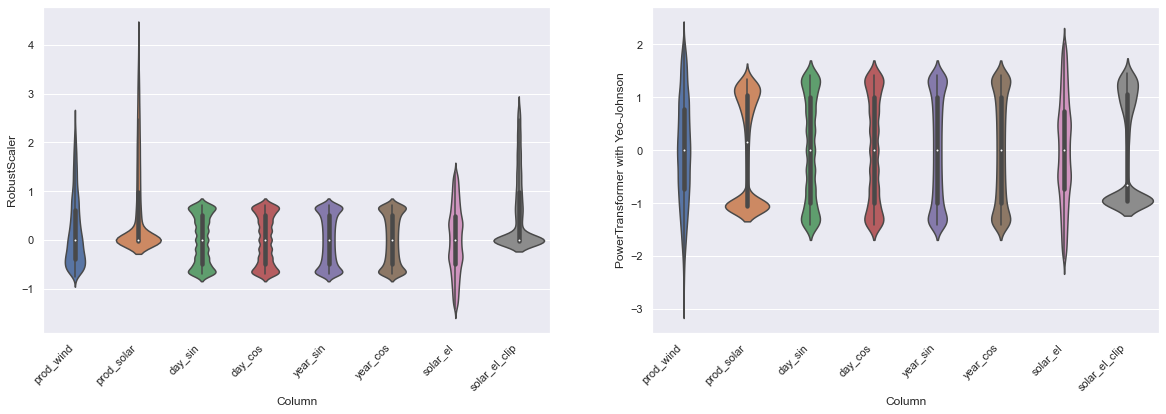

In [19]:
from sklearn.preprocessing import RobustScaler, PowerTransformer

sns.set()  # Setting seaborn as default style even if use only matplotlib
# Scale with the RobustScaler
df_rob = pd.DataFrame(RobustScaler().fit_transform(df),
                      columns=df.columns, index=df.index)
# Transform to Gaussian Distribution with Yeo-Johnson
df_tyj = pd.DataFrame(PowerTransformer(method="yeo-johnson").fit_transform(df),
                      columns=df.columns, index=df.index)

# plot normalizations
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
sns.violinplot(ax=axes[0], x='Column', y='RobustScaler',
               data=df_rob.melt(var_name='Column', value_name='RobustScaler'))
sns.violinplot(ax=axes[1], x='Column', y='PowerTransformer with Yeo-Johnson',
               data=df_tyj.melt(var_name='Column', value_name='PowerTransformer with Yeo-Johnson'))
axes[0].set_xticklabels(df.keys(), rotation=45, ha="right")
_ = axes[1].set_xticklabels(df.keys(), rotation=45, ha="right")


## Find correlations

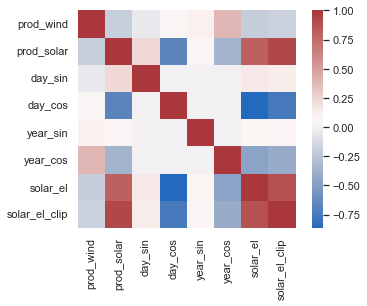

In [20]:
corr = df.corr()
cmap = sns.color_palette("vlag", as_cmap=True)
_ = sns.heatmap(corr, cmap=cmap, square=True)

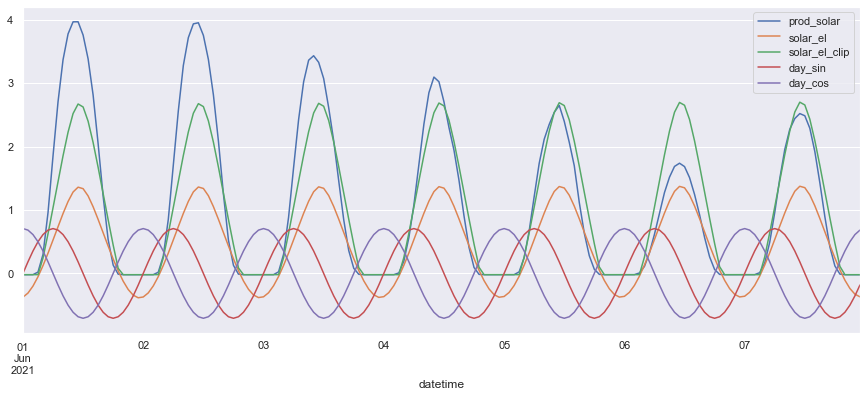

In [21]:
_ = df_rob.loc["2021-06-01":"2021-06-7"][["prod_solar", "solar_el", "solar_el_clip", "day_sin", "day_cos"]].plot(figsize=(15,6))

## Data Export

In [22]:
# export data
df.to_pickle("../data/data_prepared.pkl")